# Path To Training Data

In [1]:
import os

import matplotlib.pyplot as plt

TRAINING_DATA = "data"
IMAGE_FOLDER = "images"

# Load and Normalise Images

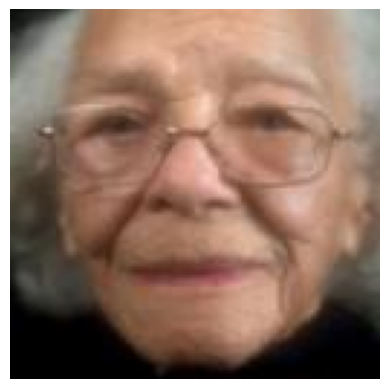

Loaded 4998 images.
[[[0.05490196 0.0627451  0.05098039]
  [0.04705882 0.05490196 0.04313725]
  [0.04313725 0.05098039 0.03921569]
  ...
  [0.63137255 0.66666667 0.64705882]
  [0.61568627 0.65098039 0.63137255]
  [0.60392157 0.63921569 0.61960784]]

 [[0.0627451  0.07058824 0.05882353]
  [0.06666667 0.0745098  0.0627451 ]
  [0.07058824 0.07843137 0.06666667]
  ...
  [0.63921569 0.6745098  0.65490196]
  [0.62352941 0.65882353 0.63921569]
  [0.61176471 0.64705882 0.62745098]]

 [[0.05490196 0.0627451  0.05098039]
  [0.0627451  0.07058824 0.05882353]
  [0.0745098  0.08235294 0.07058824]
  ...
  [0.65490196 0.69019608 0.67058824]
  [0.63529412 0.6745098  0.64313725]
  [0.61960784 0.65882353 0.62745098]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0. 

In [2]:
import matplotlib.image as mpimg
import numpy as np
import os

image_names = list(os.listdir(TRAINING_DATA))
prefix_path = lambda image_name: os.path.join(TRAINING_DATA, image_name)
image_paths = list(map(prefix_path, image_names))
images = list(map(mpimg.imread, image_paths))

plt.imshow(images[0])
plt.axis("off")
plt.show()

# Normalise RGB values into range [0, 1]
images = list(map(lambda image: image / 255.0, images))

print(f"Loaded {len(images)} images.")
print(images[0])

# Read Age and Gender Data

In [3]:
get_age = lambda image_name: int(image_name.split("_")[0])
get_gender = lambda image_name: int(image_name.split("_")[1])

age_labels = np.array(tuple(map(get_age, image_names)))
gender_labels = np.array(tuple(map(get_gender, image_names)))

print(age_labels)
print(gender_labels)

[100 100  10 ...   9   9   9]
[1 1 0 ... 0 1 1]


# Data Preprocessing

1. Shuffle the data for create a random distribution
2. Split the data into test and validation
3. Perform data augmentation

In [4]:
import random
from tensorflow.keras import layers, Sequential
import tensorflow as tf

random.seed(0)
data = list(zip(images, age_labels, gender_labels))
random.Random(0).shuffle(data)
images, age_labels, gender_labels = zip(*data)
images, age_labels, gender_labels = list(images), np.array(age_labels), np.array(gender_labels)
print(age_labels)
training_quantity = int(len(images) * 0.8)

training_images = images[:training_quantity]
training_ages = age_labels[:training_quantity]
training_gender = gender_labels[:training_quantity]

validation_images = images[training_quantity:]
validation_ages = age_labels[training_quantity:]
validation_gender = gender_labels[training_quantity:]

# With a large dataset the number of images may be large. Our slices will copy the data meaning we can get rid of the duplicates.
del images, age_labels, gender_labels

data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),  # Flip left-right
        layers.RandomRotation(0.1),  # Rotate by 10%
        layers.RandomTranslation(0.1, 0.1),  # Shift in height/width ±10%
        layers.GaussianNoise(0.01)  # Add Gaussian
    ]
)
training_dataset = (
    tf.data.Dataset.from_tensor_slices((training_images, (training_ages, training_gender)))
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    tf.data.Dataset.from_tensor_slices((validation_images, (validation_ages, validation_gender)))
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

[40  7 20 ...  1 43 39]


# Visualising Our Data

[40  7 20 ... 28 26 88]
Training Data Set Metrics:
Maximum Age - 116
Minimum Age - 1
Males - 2100
Proportion of males in training data 52.526263131565784%
Females - 1898
Proportion of females in training data 47.473736868434216%


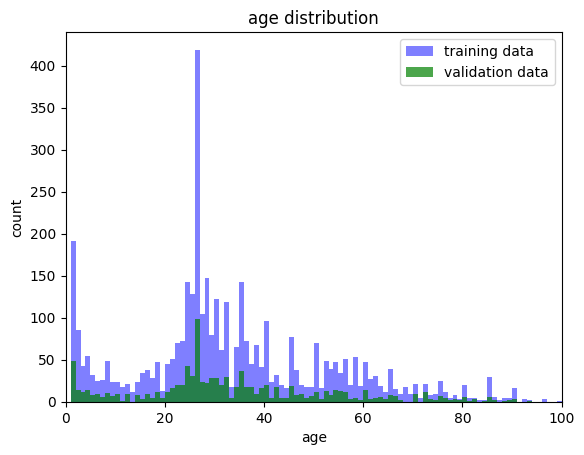

In [5]:
# check for imbalance in the data
training_male_count = np.sum(training_gender == 0)
training_female_count = np.count_nonzero(training_gender == 1)
print(training_ages)
print("Training Data Set Metrics:")
print(f"Maximum Age - {np.max(training_ages)}")
print(f"Minimum Age - {np.min(training_ages)}")
print(f"Males - {training_male_count}")
print(f"Proportion of males in training data {(training_male_count / training_gender.size) * 100}%")
print(f"Females - {training_female_count}")
print(f"Proportion of females in training data {(training_female_count / training_gender.size) * 100}%")

# fixed bin size
bins = np.arange(-200, 200, 1)  # fixed bin size
plt.xlim([0, training_ages.max() + 1])
plt.hist(training_ages, bins=bins, alpha=0.5, color="blue", label="training data")
plt.xlabel('age')
plt.ylabel('count')

bins = np.arange(-200, 200, 1)  # fixed bin size
plt.xlim([0, validation_ages.max()])
plt.hist(validation_ages, bins=bins, alpha=0.7, color="green", label="validation data")
plt.title('age distribution')
plt.xlabel('age')
plt.legend()
plt.ylabel('count')
plt.show()

# Custom Model Architecture

In [12]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models, utils
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class ConvolutionalPredictionModel(models.Model):
    def __init__(self):
        inputs = layers.Input(shape=(128, 128, 3))

        # 1st block (cnn) - output size (62*62*96)
        x = layers.Conv2D(filters=8, kernel_size=(5, 5), strides=(2, 2), padding="valid")(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)

        # 2nd block (mp) - output size (31*31*96)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

        # 3rd block (cnn) - output size (31*31*256)
        x = layers.Conv2D(16, kernel_size=(3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)

        # 4th block (mp) - output size (15*15*256)
        x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)

        # 6th block (cnn) - output size (15*15*384)
        x = layers.Conv2D(32, kernel_size=(3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)

        # 7th block (cnn) - output size (15*15*256)
        x = layers.Conv2D(16, kernel_size=(3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)

        # 8th block (mp) - ouptut size (6*6*256) under 10*10 limit
        x = layers.MaxPool2D(pool_size=(5, 5), strides=(2, 2))(x)

        # 9th block (flatten) - output size (9216)
        x = layers.Flatten()(x)

        # 10th block (fnn) - output size (4096)
        x = layers.Dense(576, kernel_regularizer=l2(0.001))(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        x = layers.Dropout(0.5)(x)

        # 11th block (fnn) - output size (2048)
        x = layers.Dense(288, kernel_regularizer=l2(0.001))(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        x = layers.Dropout(0.5)(x)

        # output
        age_output = layers.Dense(1, activation="linear", name="age_output")(x)  # Linear activation for regression
        gender_output = layers.Dense(1, activation="sigmoid", name="gender_output")(
            x
        )  # Sigmoid for binary classification

        super().__init__(inputs=inputs, outputs=[age_output, gender_output])


custom_model = ConvolutionalPredictionModel()
custom_model.summary()

utils.plot_model(custom_model, to_file=os.path.join("images", "model_architecture"), show_shapes=True, dpi=100)

Model: "convolutional_prediction_model_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 62, 62, 8) │        608 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62, 8) │         32 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 62, 62, 8) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 31, 31, 8) │          0 │ leaky_re_lu_6[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 31, 31,    │      1,168 │ max_pooling2d_9[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │         64 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 15, 15,    │          0 │ leaky_re_lu_7[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 15, 15,    │      4,640 │ max_pooling2d_10… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 15, 15,    │      4,624 │ leaky_re_lu_8[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │         64 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 6, 6, 16)  │          0 │ leaky_re_lu_9[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 576)       │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 510,434 (1.95 MB)

 Trainable params: 510,290 (1.95 MB)

 Non-trainable params: 144 (576.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


# Compile and Train Model

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=0.0001, weight_decay=0.0000001, beta_1=0.9, beta_2=0.999, epsilon=1e-8
)

custom_model.compile(
    loss={"age_output": "mse", "gender_output": "binary_crossentropy"},
    loss_weights={"age_output": 1.0, "gender_output": 100.0, }, optimizer=optimizer,
    metrics={"age_output": "mae", "gender_output": "accuracy"}
)

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=25, min_delta=0.0001)

training_history_1 = custom_model.fit(
    training_dataset, epochs=2, callbacks=[early_stopping], validation_data=validation_dataset
)
custom_model.save(os.path.join("models", "custom_model.keras"))

Epoch 1/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - age_output_loss: 519.3939 - age_output_mae: 17.4471 - gender_output_accuracy: 0.5343 - gender_output_loss: 1.3653 - loss: 656.9724 - val_age_output_loss: 1061.8262 - val_age_output_mae: 26.7143 - val_gender_output_accuracy: 0.5960 - val_gender_output_loss: 0.6804 - val_loss: 1129.0822
Epoch 2/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - age_output_loss: 399.2726 - age_output_mae: 15.3209 - gender_output_accuracy: 0.5420 - gender_output_loss: 1.0847 - loss: 508.7545 - val_age_output_loss: 642.4777 - val_age_output_mae: 19.4829 - val_gender_output_accuracy: 0.6640 - val_gender_output_loss: 0.6402 - val_loss: 707.6932


# Draw Custom Model Learning Curve

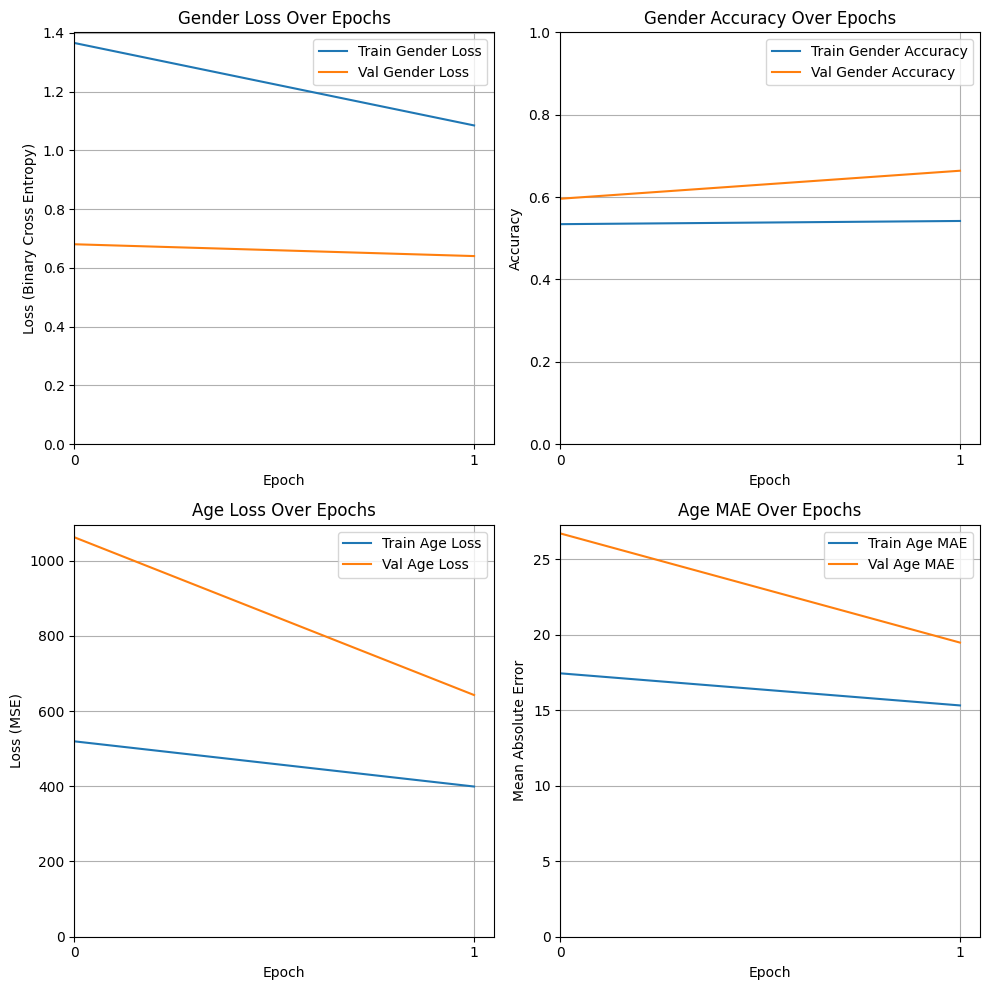

In [8]:
import matplotlib.ticker as mticker


# We will reuse this later.
def graph_history(history):
    # Create a figure with 2 subplots side by side
    fig = plt.figure(figsize=(10, 10))

    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)

    # Plot: Gender Loss
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax1.plot(history.history['gender_output_loss'], label='Train Gender Loss')
    ax1.plot(history.history['val_gender_output_loss'], label='Val Gender Loss')
    ax1.set_title('Gender Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (Binary Cross Entropy)')
    ax1.legend()
    ax1.grid(True)
    ax1.set_xlim(left=0)
    ax1.set_ylim(bottom=0)

    # Plot: Gender Acc
    ax2.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax2.plot(history.history['gender_output_accuracy'], label='Train Gender Accuracy')
    ax2.plot(history.history['val_gender_output_accuracy'], label='Val Gender Accuracy')
    ax2.set_title('Gender Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    ax2.set_xlim(left=0)
    ax2.set_ylim(bottom=0, top=1)

    # Plot: Age Loss
    ax3.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax3.plot(history.history['age_output_loss'], label='Train Age Loss')
    ax3.plot(history.history['val_age_output_loss'], label='Val Age Loss')
    ax3.set_title('Age Loss Over Epochs')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss (MSE)')
    ax3.legend()
    ax3.grid(True)
    ax3.set_xlim(left=0)
    ax3.set_ylim(bottom=0)

    # # Plot: Age MAE
    ax4.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax4.plot(history.history['age_output_mae'], label='Train Age MAE')
    ax4.plot(history.history['val_age_output_mae'], label='Val Age MAE')
    ax4.set_title('Age MAE Over Epochs')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Mean Absolute Error')
    ax4.legend()
    ax4.grid(True)
    ax4.set_xlim(left=0)
    ax4.set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()


graph_history(training_history_1)

# Feature Extraction Model Architecture

In [14]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.utils import plot_model


@register_keras_serializable()
class FeatureExtractionModel(models.Model):
    def __init__(self):
        # 1. Define the input layer for your native image size.
        inputs = Input(shape=(128, 128, 3))

        # 2. Add a resizing layer to adjust to the pre-trained model's expected input size.
        # check if resizing in the model is okay

        x = inputs

        # 3. Load the pre-trained model without an input_tensor.
        base_model = ResNet152V2(weights='imagenet', include_top=False)
        base_model.trainable = False

        # 4. Pass the resized tensor through the base model.
        x = base_model(x, training=False)
        x = GlobalAveragePooling2D()(x)

        x = layers.Dense(512, kernel_regularizer=l2(0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        x = layers.Dropout(0.5)(x)

        x = layers.Dense(256, kernel_regularizer=l2(0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        x = layers.Dropout(0.5)(x)

        # Example heads for gender and age.
        age_output = Dense(1, activation='linear', name='age_output')(x)
        gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
        super().__init__(inputs=inputs, outputs=[age_output, gender_output])


feature_extraction_model = FeatureExtractionModel()
feature_extraction_model.summary()
plot_model(feature_extraction_model, show_shapes=True, dpi=100)

230973440/234545216 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet152v2_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- retrieval incomplete: got only 231360303 out of 234545216 bytes

# Compile and Train Feature Extraction Model

In [ ]:
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=1e-3, weight_decay=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-8, )

feature_extraction_model.compile(
    loss={"age_output": "mse", "gender_output": "binary_crossentropy"},
    loss_weights={"age_output": 1.0, "gender_output": 100.0, }, optimizer=optimizer,
    metrics={"age_output": "mae", "gender_output": "accuracy"}
)

callback = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10, min_delta=0.0001)
training_history_2 = feature_extraction_model.fit(
    training_dataset, epochs=2, callbacks=[callback], validation_data=validation_dataset
)

feature_extraction_model.save(os.path.join("models", "feature_extraction_model.keras"))

# Draw Feature Extraction Model Learning Curve

In [ ]:
graph_history(training_history_2)